Label Agreement Analysis
This notebook compares agreement between **true labels**, **model predictions**, and **Claude‑generated labels**.

**Sections**
1. Imports & setup  
2. Load data  
3. (Optional) data cleaning  
4. Agreement metrics  
5. Visualisations  

**Outputs**  
* Bar chart of overall agreement  
* Three pairwise confusion matrices  
* Stacked per-class three-way agreement plot  
* Correlation coefficients (Pearson & Spearman)  
* Violin/box plot of confidence by (dis)agreement  
* Line plot of agreement rate across confidence buckets  
* Identification of a confidence “breakpoint”  
* Calibration curve (reliability plot)  
* Table of high-confidence (> 0.8) disagreements


In [43]:
# 1. Imports and setup

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import warnings

plt.style.use('seaborn-v0_8-darkgrid')

FILE_PATH = '../reports/label_review/claude_labels.csv'

# Ignore pandas hashing runtime warning
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in cast",
    category=RuntimeWarning,
    module="pandas.core.util.hashing"
)

# Ignore seaborn use_inf_as_na future warning
warnings.filterwarnings(
    "ignore",
    message="use_inf_as_na option is deprecated",
    category=FutureWarning,
    module="seaborn._oldcore"
)

# Ignore seaborn grouping length-1 list-like future warning
warnings.filterwarnings(
    "ignore",
    message="When grouping with a length-1 list-like",
    category=FutureWarning,
    module="seaborn._oldcore"
)

print("Warning filters set!")

Warning filters set!


In [44]:
# 2. Load data

try:
    df = pd.read_csv(FILE_PATH)
    print(f"Loaded data with {len(df)} rows.")
    display(df.head())
except FileNotFoundError as err:
    raise FileNotFoundError(f"Could not find the file at {FILE_PATH}") from err


Loaded data with 1112 rows.


,Question,Answer,Category,text,clean_text,True,Predicted,Confidence,LabelMismatch,Claude_Category_Number,Claude_Category,Agreement
0,Methane is a compound of hydrogen with which o...,Carbon,Entertainment,Methane is a compound of hydrogen with which o...,methane is a compound of hydrogen with which o...,Entertainment,Science and Nature,2.235407,True,8,Science and Nature,False
1,Which well known cartoon character was created...,POPEYE,History,Which well known cartoon character was created...,which well known cartoon character was created...,History,Entertainment,2.136312,True,4,Entertainment,False
2,Which English cricket commentator on BBC's Tes...,Isa Guha,Entertainment,Which English cricket commentator on BBC's Tes...,which english cricket commentator on bbcs test...,Entertainment,Sport,2.100330,True,5,Sport,False
3,"In 1924, prior to his career as a paediatricia...",ROWING,Science and Nature,"In 1924, prior to his career as a paediatricia...",in 1924 prior to his career as a paediatrician...,Science and Nature,Sport,2.019249,True,5,Sport,False
4,Oceanic Airlines are a fictitious airline who ...,LOST,Lifestyle,Oceanic Airlines are a fictitious airline who ...,oceanic airlines are a fictitious airline who ...,Lifestyle,Entertainment,1.894728,True,4,Entertainment,False


In [45]:
# ## 3. (Optional) Data cleaning  
# Uncomment and adapt if need to normalise datatypes or fill missing values.

# %%
# df['True'] = df['True'].astype(str).fillna('Unknown')
# df['Predicted'] = df['Predicted'].astype(str).fillna('Unknown')
# df['Claude_Category'] = df['Claude_Category'].astype(str).fillna('Unknown')

In [46]:

# 4. Agreement calculations

agree_true_claude = (df['True'] == df['Claude_Category']).mean()
agree_pred_claude = (df['Predicted'] == df['Claude_Category']).mean()

print("\n🔢 **Agreement scores**")
print(f"True vs Claude     : {agree_true_claude:.2%}")
print(f"Predicted vs Claude: {agree_pred_claude:.2%}")


🔢 **Agreement scores**
True vs Claude     : 38.13%
Predicted vs Claude: 46.40%


In [47]:
# 5.1 Helper for confusion matrices

def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Display a normalised confusion matrix with raw counts overlayed."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )
    # overlay raw counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                plt.text(
                    j + 0.5,
                    i + 0.77,
                    f'{cm[i, j]}',
                    ha='center',
                    va='center',
                    color='black' if cm_norm[i, j] < .7 else 'white',
                    fontsize=8
                )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

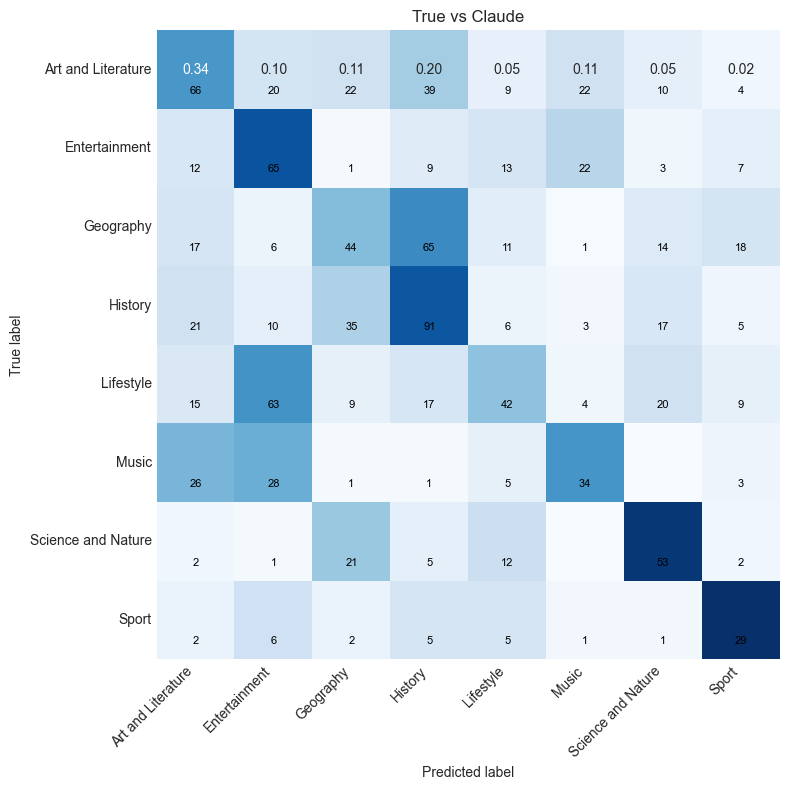

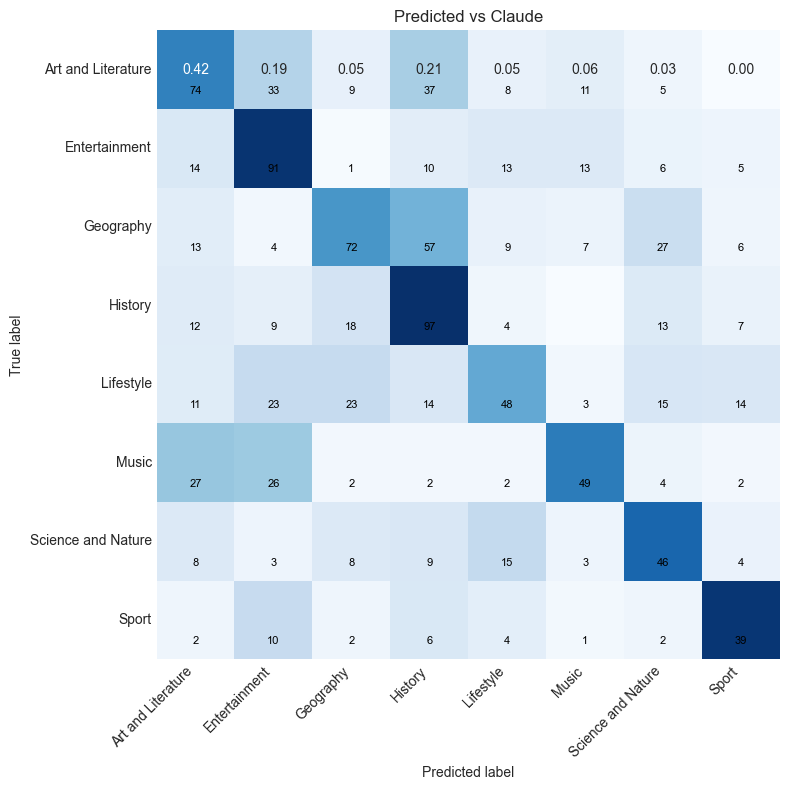

In [48]:
# 5.2 Pairwise confusion matrices

all_categories = sorted(pd.unique(df[['True', 'Predicted', 'Claude_Category']].values.ravel('K')))
plot_confusion_matrix(df['True'], df['Claude_Category'], all_categories, 'True vs Claude')
plot_confusion_matrix(df['Predicted'], df['Claude_Category'], all_categories, 'Predicted vs Claude')


## Interpretation

# Topic clusters

Art & Literature ↔ History and Geography ↔ History show frequent crossover. 

Music ↔ Entertainment forms another clear cluster.

# Well-separated classes

Sport (and, to a degree, Entertainment) are distinct enough that Claude almost never confuses them with anything else.

# Ambiguous buckets

Lifestyle and Art & Literature are somewhat grabag categories with lots of leakage in and out. 
This is not surprising, as A&L is designed to take in extra questions from Music in particular, and lifestyle is inherently "nebulous".

In [49]:
# %% [markdown]
# ## 6. Confidence‑vs‑agreement analysis
# 
# We now investigate whether the **model's prediction confidence** is informative about its agreement with Claude.
# 
# * *Pred_vs_Claude_Agree* = 1 if the model and Claude assign the same label, else 0.  
# * We'll compute a Pearson correlation, visualise the confidence distributions, and plot the agreement rate across confidence buckets.  
# * Finally, we'll highlight a **"breakpoint" confidence threshold** where disagreement starts to rise sharply.


# --- 6.0 Sanity‑check confidence column ---------------------------------------------------
if 'Confidence' not in df.columns:
    raise KeyError("Column 'Confidence' not found in the CSV – please add it and re-run.")

_df = df.copy()
_df['Confidence'] = pd.to_numeric(_df['Confidence'], errors='coerce')
_df = _df.dropna(subset=['Confidence'])
_df['Pred_vs_Claude_Agree'] = (_df['Predicted'] == _df['Claude_Category']).astype(int)
_df = _df.replace([np.inf, -np.inf], np.nan)  # handle infinities
_df = _df.dropna(subset=['Pred_vs_Claude_Agree'])

print(f"Using {_df.shape[0]} rows after cleaning confidence/agreement flags.")



Using 1112 rows after cleaning confidence/agreement flags.


In [50]:


# --- 6.1 Correlation ---------------------------------------------------------------------
corr = _df['Confidence'].corr(_df['Pred_vs_Claude_Agree'])
print(f"Pearson correlation between confidence and Claude‑agreement: {corr:.3f}")



Pearson correlation between confidence and Claude‑agreement: 0.365


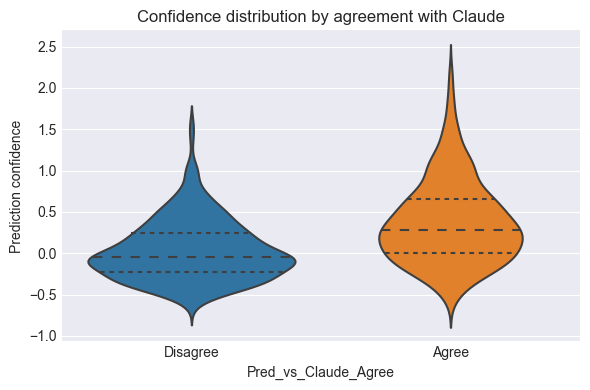

In [51]:


# --- 6.2 Distribution by agreement --------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.violinplot(x='Pred_vs_Claude_Agree', y='Confidence', data=_df, inner='quartile')
plt.xticks([0, 1], ['Disagree', 'Agree'])
plt.ylabel('Prediction confidence')
plt.title('Confidence distribution by agreement with Claude')
plt.tight_layout()
plt.show()



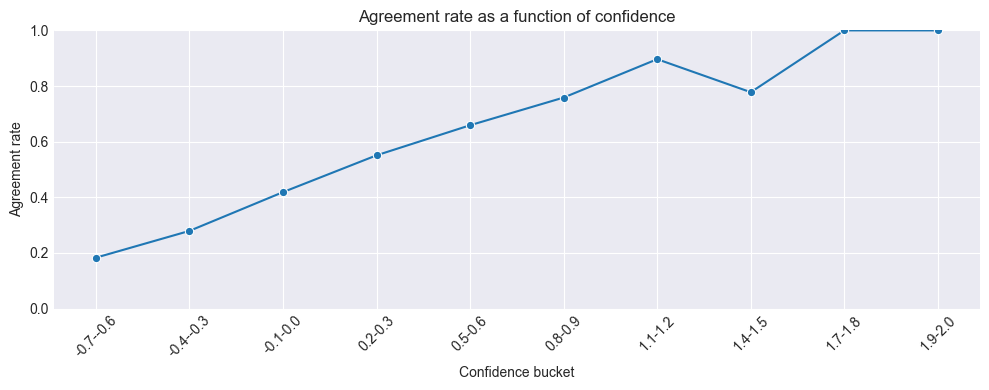

In [52]:


# --- 6.3 Agreement rate vs confidence buckets --------------------------------------------
max_conf = _df['Confidence'].max()
min_conf = _df['Confidence'].min()
bins = np.linspace(min_conf, max_conf, 11)  # 10 buckets from 0 to max confidence
labels = [f"{b:.1f}-{b+0.1:.1f}" for b in bins[:-1]]
_df['conf_bin'] = pd.cut(_df['Confidence'], bins=bins, labels=labels, include_lowest=True, right=False)

bucket_stats = (_df.groupby('conf_bin',observed=True)['Pred_vs_Claude_Agree']
                  .agg(['count', 'mean'])
                  .rename(columns={'mean': 'agreement_rate'}))

plt.figure(figsize=(10, 4))
sns.lineplot(x=bucket_stats.index, y=bucket_stats['agreement_rate'], marker='o')
plt.ylim(0, 1)
plt.ylabel('Agreement rate')
plt.xlabel('Confidence bucket')
plt.title('Agreement rate as a function of confidence')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [53]:
# --- 6.4 Simple breakpoint heuristic ------------------------------------------------------
# Define breakpoint as the *highest* confidence bucket where agreement falls below the overall mean
overall_agreement = _df['Pred_vs_Claude_Agree'].mean()
low_agree_buckets = bucket_stats[bucket_stats['agreement_rate'] < overall_agreement]

if not low_agree_buckets.empty:
    breakpoint_bin = low_agree_buckets.index[0]
    print(f"\n⚠️  Breakpoint detected: agreement drops below overall ({overall_agreement:.2%}) starting at confidence < {breakpoint_bin.split('-')[0]}")
else:
    print("\n✅ No breakpoint: agreement in every bucket meets or exceeds overall average.")



⚠️  Breakpoint detected: agreement drops below overall (46.40%) starting at confidence < 


## Interpretation

Clear positive association between confidence of our LinearSVC model and agreement with Claude. 
This suggests that in these "problem" case, many were indeed errors in the original labelling rather than errors by our model.

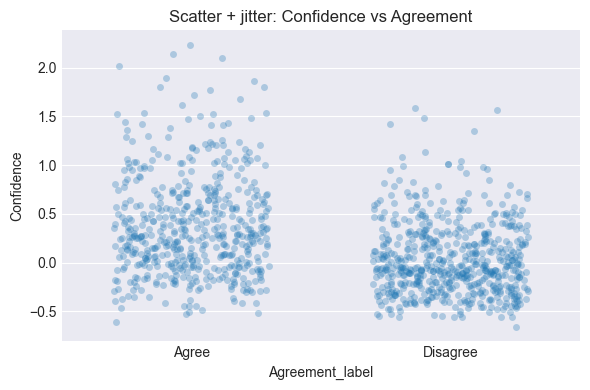

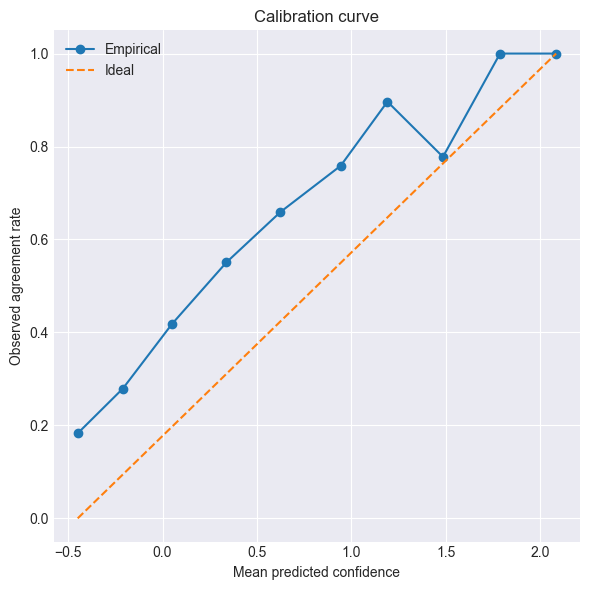

In [54]:
# 7. Additional analyses: scatter & calibration

# Scatter + jitter of every point
plt.figure(figsize=(6,4))
_df['Agreement_label'] = _df['Pred_vs_Claude_Agree'].map({0: 'Disagree', 1: 'Agree'})
sns.stripplot(x='Agreement_label', y='Confidence', data=_df, jitter=0.3, alpha=0.3)
plt.ylabel('Confidence')
plt.title('Scatter + jitter: Confidence vs Agreement')
plt.tight_layout()
plt.show()


# Calibration curve

# Build calibration using the same bins defined earlier
_df_cal = _df.copy()
_df_cal['cal_bin'] = pd.cut(_df_cal['Confidence'], bins=bins, include_lowest=True, right=False)
cal = (
    _df_cal
    .groupby('cal_bin', observed=True)
    .agg(
        observed_rate=('Pred_vs_Claude_Agree','mean'),
        mean_confidence=('Confidence','mean')
    )
    .dropna()
)

plt.figure(figsize=(6,6))
plt.plot(cal['mean_confidence'], cal['observed_rate'], marker='o', label='Empirical')
plt.plot([cal['mean_confidence'].min(), cal['mean_confidence'].max()], [0,1], '--', label='Ideal')
plt.xlabel('Mean predicted confidence')
plt.ylabel('Observed agreement rate')
plt.title('Calibration curve')
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# 8.1. High-confidence disagreement cases
# List all examples where the model was **highly confident** (> 0.8) but Claude disagreed.

high_conf_disagree = _df[(_df['Pred_vs_Claude_Agree'] == 0) & (_df['Confidence'] > 0.8)]
print(f"Found {len(high_conf_disagree)} high-confidence disagreements:")
display(high_conf_disagree[['Question', 'Answer','Predicted', 'Claude_Category', 'Confidence']])


Found 20 high-confidence disagreements:


,Question,Answer,Predicted,Claude_Category,Confidence
12,In 2006 Kenneth Branagh directed a film versio...,Stephen FRY,Entertainment,Art and Literature,1.580695
13,The Harrington jacket got its name from a char...,Peyton Place,Entertainment,Lifestyle,1.569396
20,Which piece of classical music by JS Bach was ...,Toccata and Fugue,Music,Art and Literature,1.479392
25,Which American mystery and crime author wrote ...,Jeffrey DEAVER,Art and Literature,Entertainment,1.420458
30,The Christmas carol O Little Town of Bethlehem...,Ralph Vaughan Williams,Music,Art and Literature,1.344475
49,"""Losing my mind"" sang by Sally is a number fro...",FOLLIES,Music,Art and Literature,1.137130
55,The name of which dairy product is used in bas...,Cheese,Lifestyle,Sport,1.079119
66,"Which castle in Bavaria, commissioned by King ...",Neuschwanstein,History,Geography,1.043418
74,"Which British charity, named for the man who f...",BARNARDO'S,Lifestyle,Geography,1.015259
76,"Still the 7th largest city in modern day Peru,...",CUSCO or CUZCO,Geography,History,1.007544


## Interpretation

Many of these disagreements are precisely the edge cases where we would expect issues. Ambiguity between Music + A&L/Ent, or History + Geography. Some more recherché disagreements actually favour the model (e.g. the "fact" being question in Q 111 is the history fact rather than the sport, even though it is framed on a boardgame, likewise the Barnardo's question would most likely be called "lifestyle"). 

As such, my human credence in the proposition "defer to model rather than human label in high confidence cases" is increasing.

In [56]:
# 8.2. Mid-confidence disagreement cases
# List all examples where the model was **highly confident** (> 0.8) but Claude disagreed.

mid_conf_disagree = _df[
    (_df['Pred_vs_Claude_Agree'] == 0) &
    (_df['Confidence'] > 0.6) &
    (_df['Confidence'] <= 0.8)
]
print(f"Found {len(mid_conf_disagree)} mid-confidence disagreements:")
display(mid_conf_disagree[['Question', 'Answer','Predicted', 'Claude_Category', 'Confidence']])


Found 26 mid-confidence disagreements:


,Question,Answer,Predicted,Claude_Category,Confidence
114,"The gender-neutral, environmentally friendly c...",PHARRELL WILLIAMS,Music,Lifestyle,0.792548
116,The winning horse in the 2017 running of the 2...,Churchill,History,Sport,0.782950
117,What was the name of the currency used in Brit...,"shilling [accept specific answers, e.g. “Kenya...",Geography,History,0.781937
127,"The book ""Mastering the Art of French Cooking""...",Julia CHILDS,Art and Literature,Lifestyle,0.749268
136,What was the name of the 1990s British game sh...,"WIN, LOSE OR DRAW",Sport,Entertainment,0.722833
137,What word fills the blanks in the lyrics of th...,MOONBEAMS,Music,Entertainment,0.721567
139,The 1990 novel Postmortem marked the first app...,Kay SCARPETTA,Art and Literature,Entertainment,0.717685
147,Which Finnish-American architect designed the ...,Eero SAARINEN,Geography,History,0.698260
149,Which seven time Grammy award winning Singer/ ...,Al JARREAU,Entertainment,Music,0.694971
150,Bishop Grosseteste University is located in wh...,LINCOLN,Geography,History,0.694863


## Interpretation

More "genuine" errors from the LinearSVC model in this bucket (Ben Jonson should be A&L, Superman should be entertainment, the Wine, Lose or Draw questions should be entertainment, Childs should be lifestylend Churchill should be sport). Several of those are still borderline, though. Given, again, that this is chosen from a sample where the model had high confidence AND disagreed with the 'True' label, our confidence in the model's accuracy when it produces a confident guess is updating yet more positively. 


In [57]:
# 8.2. Low-confidence disagreement cases
# List all examples where the model was **highly confident** (> 0.8) but Claude disagreed.

mid_conf_disagree = _df[
    (_df['Pred_vs_Claude_Agree'] == 0) &
    (_df['Confidence'] > 0.2) &
    (_df['Confidence'] <= 0.6)
]
print(f"Found {len(mid_conf_disagree)} mid-confidence disagreements:")
display(mid_conf_disagree[['Question', 'Answer','Predicted', 'Claude_Category', 'Confidence']])


Found 119 mid-confidence disagreements:


,Question,Answer,Predicted,Claude_Category,Confidence
191,What streaming service provided by Amazon is t...,Amazon PRIME Video,Lifestyle,Entertainment,0.596990
194,Which American slang term for a common starchy...,Tater,Lifestyle,Sport,0.587017
200,A campaign T-shirt “Sparkle with Starmer” has ...,GLITTER,History,Lifestyle,0.572115
205,The name of what item of clothing provided Tay...,CARDIGAN,Lifestyle,Music,0.565474
206,What superlative name is given to a boneless c...,SUPREME,Science and Nature,Lifestyle,0.558786
...,...,...,...,...,...
457,"Which Scottish island, also close to Barra and...",Mingulay,Music,Geography,0.218967
461,"Who wrote ""The Girl with the Dragon Tattoo""?",Stieg Larson,Art and Literature,History,0.208383
462,Which real life person did Ariana Debose play ...,Mary WILSON,Music,Entertainment,0.207973
465,"The model village of New Earswick, north of Yo...",Joseph Rowntree,Lifestyle,History,0.204658
